# HW2 - Type 1 Diabetes Detection

### In this assignment, we will do the following:
* Explore the data provided.
* Implement linear and non-linear classifiers.
* Model optimization with k-fold cross validation
* Evaluate your model performances with appropriate metrics.
* Present a 2d visualization of multi-featured data.
*Use feature selection tools.

### Theory Questions

#### Question 1

To evaluate how well our model performs at T1D classification, we need to have evaluation
metrics that measures of its performances/accuracy. Which evaluation metric is more
important to us: model accuracy or model performance? Give a simple example that
illustrates your claim.

#### Answer 1

Accuracy is the ratio of number of correct predictions to the total number of input samples.
Evaluating a model according to its performance includes a confusion matrix and determines the values of sensitivity and specificity.
In our case, we would prefer to evaluate the model based on its performance rather than accuracy. While classification accuracy 
has it's perks, it tends to create a false sense of achieving high accuracy. 
As stated in the theoretical background, the incidence of T1D is 0.33%, i.e. even a naive classifier who determine that every sample classifying as "False" would have an accuracy of 99.67% which is great, but we will misclassify sick people who need treatment. The cost of failing to diagnose the disease of a sick person is much higher than the cost of sending a healthy person to more tests. 


#### Question 2

T1D is often associated with other comorbidities such as a heart attack. You are asked to
design a ML algorithm to predict which patients are going to suffer a heart attack. Relevant
patient features for the algorithm may include blood pressure (BP), body-mass index (BMI),
age (A), level of physical activity (P), and income (I). You should choose between two
classifiers: the first uses only BP and BMI features and the other one uses all of the features
available to you. Explain the pros and cons of each choice.

#### Answer 2

Training a model based on only two features would be easier to visualize and interpret, would reduce computational cost, and probably would need less samples.
on the other hand, elimination of relevant features can degrade the quality of the prediction.
Training a model using all features would contribute to more accurate prediction. But the larger the number of features, the greater the number of samples required to make a good prediction (exponential increase), and there might be some irrelevant features (like income) that may reduce the prediction.
We will choose the model that based on all the features and by using machine learning tools we learn we can ignore irrelevant features by using Lasso regularization for instance. 


#### Question 3

A histologist wants to use machine learning to tell the difference between pancreas biopsies
that show signs of T1D and those that do not. She has already come up with dozens of
measurements to take, such as color, size, uniformity and cell-count, but she isn’t sure which
model to use. The biopsies are really similar, and it is difficult to distinguish them from the
human eye, or by just looking at the features. Which of the following is better: logistic
regression, linear SVM or nonlinear SVM? Explain your answer.

#### Answer 3

Since the biopsies cannot be separate based on looking at the features themselves, we can assume that they cannot be linearly separable. If we run a linear model on non-linearly separable data we will get poor results, so we would choose the non-linear SVM model. 

#### Question 4

What are the differences between LR and linear SVM and what is the difference in the effect/concept of their hyper-parameters tuning?

#### Answer 4

In theory LR and SVM with linear Kernel would generate very similar results, yet in reality there are some differences:

-	SVM can handle non-linear solutions using Kernel trick whereas logistic regression can only handle linear solutions.
-	SVM tries to find the widest possible separating margin, while Logistic Regression optimizes the log likelihood function, with probabilities modeled by the sigmoid function.
-	Logistic Regression produces probabilistic values while SVM produces 1 or 0.
-	SVM handles outliers better than LR.
-	For the kernel space, SVM is faster because its stores just support vectors.

In terms of hyper parameters, in LR we can find λ (the regularization parameter). Regularization is used to avoid over-fitting on the data. Higher the λ, higher will be the regularization term and the solution will be highly biased. Lower the λ, solution will be of high variance.
In SVM the hyper parameters are C (penalty parameter) and γ (relevant only for RBF SVM). If C is small, a large margin decision boundary is chosen at the expense of a greater number of misclassifications. If C is large, SVM tries to minimize the number of misclassified examples which results in a decision boundary with a smaller margin. 

The effect of raising these two hyper parameters is the opposite, if we increase the λ parameter in the LR model we get a less accurate fit to the training set, and if we raise C parameter in the SVM model we get a better fit to the training set.


#### Data Loading 

In [64]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate, KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, log_loss, roc_auc_score, confusion_matrix, plot_roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from mpl_toolkits import mplot3d
from matplotlib import cm
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.decomposition import PCA

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
warnings.filterwarnings('ignore')
mpl.style.use(['ggplot']) 

random.seed(42)

#### Q1
Load the data

In [2]:
path = '.\HW2_data.csv'

In [3]:
dataset = pd.read_csv(path)
dataset.head()

,Age,Gender,Increased Urination,Increased Thirst,Sudden Weight Loss,Weakness,Increased Hunger,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Hair Loss,Obesity,Diagnosis,Family History
0,45,Male,No,No,No,Yes,No,No,No,Yes,No,No,Yes,No,Yes,No,Negative,0
1,42,Male,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,Negative,0
2,45,Male,Yes,Yes,No,Yes,No,Yes,No,No,No,Yes,No,No,Yes,No,Positive,0
3,59,Female,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Positive,1
4,40,Female,Yes,Yes,Yes,Yes,No,No,Yes,Yes,No,No,Yes,Yes,No,No,Positive,0


#### Preprocessing

Replacing string parameters to be integers (0 / 1)

In [4]:
dataset = dataset.replace('No', 0).replace('Yes', 1).replace('Positive', 1).replace('Negative', 0).replace('Male', 0).replace('Female', 1)

In [5]:
dataset.head()

,Age,Gender,Increased Urination,Increased Thirst,Sudden Weight Loss,Weakness,Increased Hunger,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Hair Loss,Obesity,Diagnosis,Family History
0,45,0,0,0.0,0.0,1,0.0,0.0,0,1.0,0,0,1,0.0,1,0,0,0
1,42,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0.0,1,0,0,0
2,45,0,1,1.0,0.0,1,0.0,1.0,0,0.0,0,1,0,0.0,1,0,1,0
3,59,1,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0.0,0,0,1,1
4,40,1,1,1.0,1.0,1,0.0,0.0,1,1.0,0,0,1,1.0,0,0,1,0


In [6]:
keys = dataset.keys().drop('Diagnosis')

Count NaN values within the data

In [7]:
for key in keys:
    nan_count = dataset[key].isna().sum()
    if nan_count:
        print('%d NaN values found for %s' % (nan_count, key))

20 NaN values found for Increased Thirst
9 NaN values found for Sudden Weight Loss
13 NaN values found for Increased Hunger
14 NaN values found for Genital Thrush
11 NaN values found for Itching
15 NaN values found for Muscle Stiffness


In [8]:
dataset.shape

(565, 18)

We found a total number of 82 NaN values out of 9605 values (0.88% of NaN Values)

The maximum percentage of NaN values for a specific measure is 3.5%

Hence the number of NaN values is negligible

We chose to drop cases with NaN values since most of the features for this dataset are binary and estimating them could mislead the model.

In [9]:
dataset = dataset.dropna()

Seperation to features and label.

In [10]:
X = dataset[keys]
Y = dataset['Diagnosis']

In [89]:
X

,Age,Gender,Increased Urination,Increased Thirst,Sudden Weight Loss,Weakness,Increased Hunger,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Hair Loss,Obesity,Family History
0,45,0,0,0.0,0.0,1,0.0,0.0,0,1.0,0,0,1,0.0,1,0,0
1,42,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0.0,1,0,0
2,45,0,1,1.0,0.0,1,0.0,1.0,0,0.0,0,1,0,0.0,1,0,0
3,59,1,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0.0,0,0,1
4,40,1,1,1.0,1.0,1,0.0,0.0,1,1.0,0,0,1,1.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,62,0,1,0.0,0.0,1,0.0,1.0,1,1.0,1,0,1,1.0,1,1,0
519,35,0,1,0.0,0.0,0,1.0,1.0,0,0.0,1,1,0,0.0,1,0,0
562,61,1,1,0.0,0.0,0,1.0,0.0,0,0.0,1,0,0,0.0,1,0,1
563,46,0,0,0.0,0.0,1,0.0,0.0,0,1.0,0,1,0,0.0,1,0,0


In [12]:
for key in keys:
    nan_count = X[key].isna().sum()
    if nan_count:
        print('%d NaN values found for %s' % (nan_count, key))

#### Data Exploration

<AxesSubplot:ylabel='Diagnosis'>

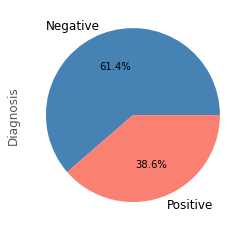

In [13]:
Y.value_counts().plot(kind='pie', labels=['Negative', 'Positive'], colors=['steelblue', 'salmon'], autopct='%1.1f%%')

We would like to look at the data to see if it makes sense.

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Gender'}>,
        <AxesSubplot:title={'center':'Increased Urination'}>,
        <AxesSubplot:title={'center':'Increased Thirst'}>],
       [<AxesSubplot:title={'center':'Sudden Weight Loss'}>,
        <AxesSubplot:title={'center':'Weakness'}>,
        <AxesSubplot:title={'center':'Increased Hunger'}>,
        <AxesSubplot:title={'center':'Genital Thrush'}>],
       [<AxesSubplot:title={'center':'Visual Blurring'}>,
        <AxesSubplot:title={'center':'Itching'}>,
        <AxesSubplot:title={'center':'Irritability'}>,
        <AxesSubplot:title={'center':'Delayed Healing'}>],
       [<AxesSubplot:title={'center':'Partial Paresis'}>,
        <AxesSubplot:title={'center':'Muscle Stiffness'}>,
        <AxesSubplot:title={'center':'Hair Loss'}>,
        <AxesSubplot:title={'center':'Obesity'}>],
       [<AxesSubplot:title={'center':'Diagnosis'}>,
        <AxesSubplot:title={'center':'Family History'}>, <Ax

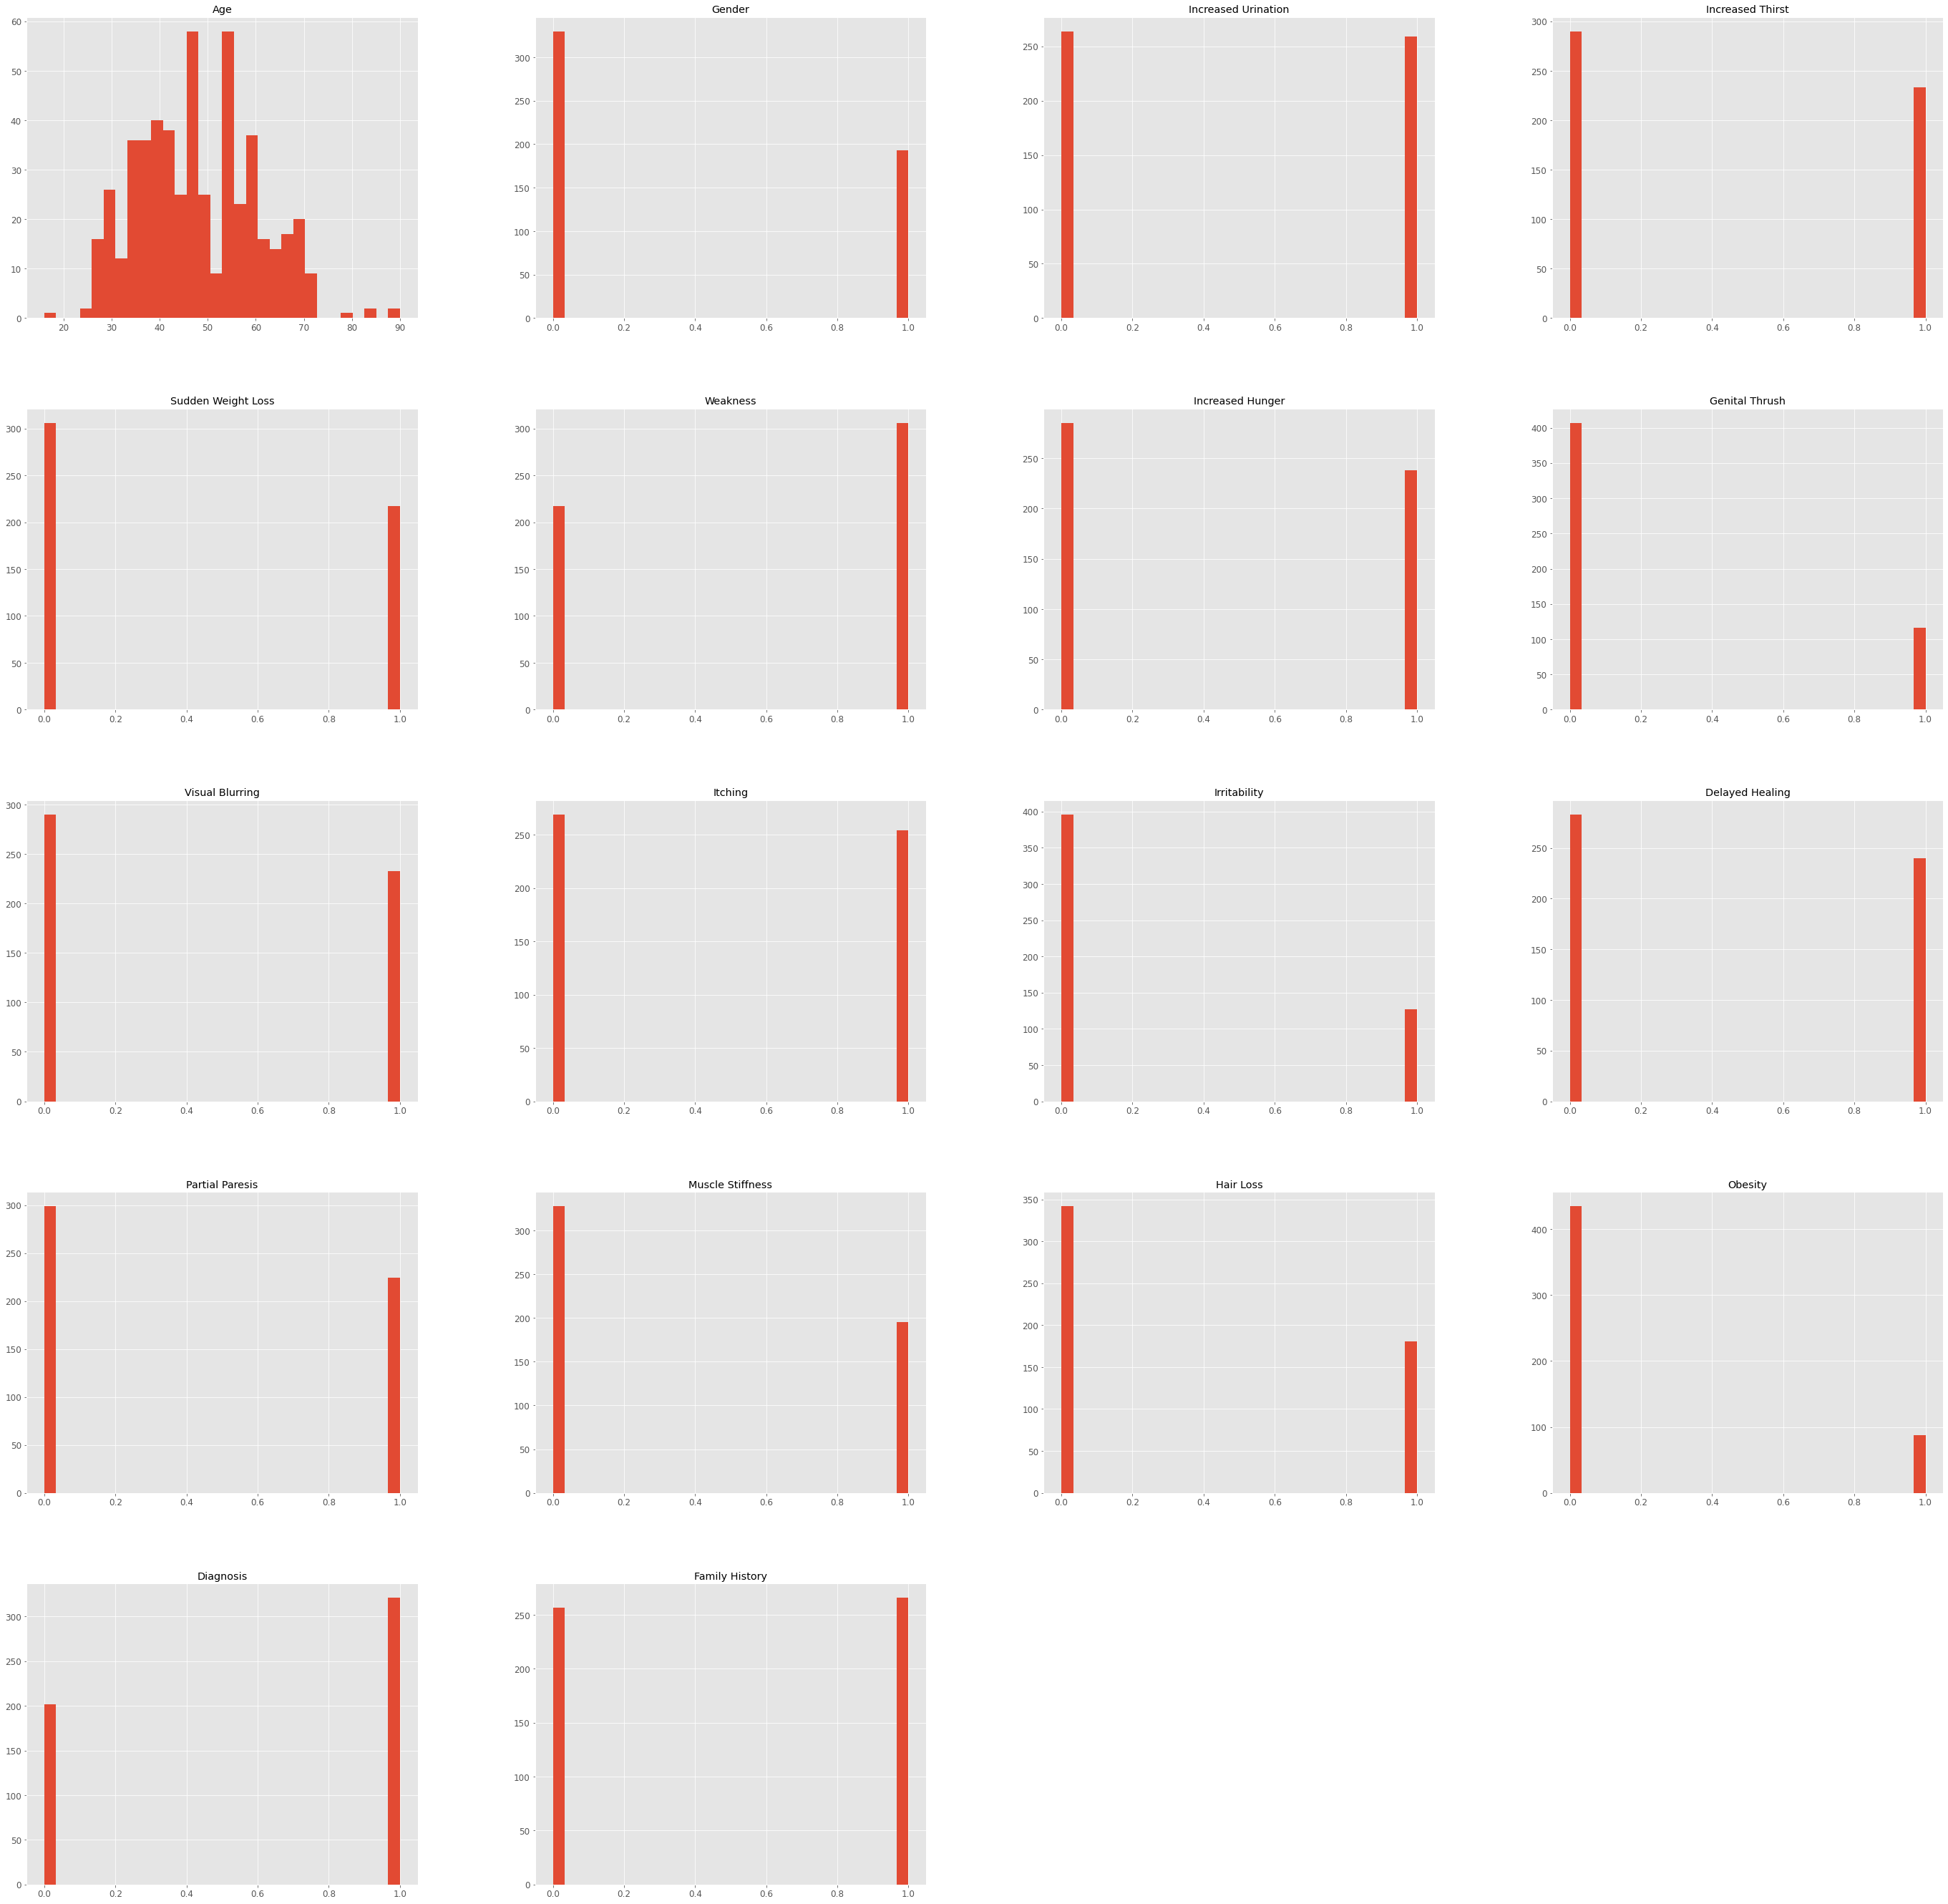

In [14]:
dataset.hist(bins= 30,figsize=(48, 48))

#### Data Exploration On The Divided Data

#### Q2
Perform a test-train split of 20% test

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [16]:
N_train = float(X_train.shape[0])
N_test = float(X_test.shape[0])

In [17]:
percent_train = lambda feat: 100 * X_train.value_counts(feat)[1] / N_train
percent_test = lambda feat: 100 * X_test.value_counts(feat)[1] / N_test

#### Q3.a
An analysis to show that the distribution of the features is similar between test and train

In [18]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Positive Feature', 'Train %', 'Test %', 'Delta %']
features = [feat for feat in X_train]

for feat in features[1:]:
    c_train = percent_train(feat)
    c_test = percent_test(feat)
    table.add_row([feat, c_train, c_test, c_train - c_test])

print(table)

+---------------------+--------------------+--------------------+---------------------+
|   Positive Feature  |      Train %       |       Test %       |       Delta %       |
+---------------------+--------------------+--------------------+---------------------+
|        Gender       | 38.038277511961724 | 32.38095238095238  |  5.657325131009344  |
| Increased Urination | 50.239234449760765 | 46.666666666666664 |  3.572567783094101  |
|   Increased Thirst  |  43.7799043062201  | 47.61904761904762  |  -3.839143312827524 |
|  Sudden Weight Loss | 40.90909090909091  | 43.80952380952381  | -2.9004329004329037 |
|       Weakness      | 57.89473684210526  | 60.95238095238095  |  -3.057644110275689 |
|   Increased Hunger  | 47.36842105263158  | 38.095238095238095 |  9.273182957393487  |
|    Genital Thrush   | 22.966507177033492 | 19.047619047619047 |  3.9188881294144444 |
|   Visual Blurring   | 44.49760765550239  | 44.76190476190476  | -0.2642971064023669 |
|       Itching       | 49.04306

##### What issues could an imbalance of features between train and test cause?

Unbalanced data can result in an improper learning process of the model. Learning is based on the training set only and is therefore affected by the prevalence of the categories in it. It is possible that when we test the model on the test set, we would get incorrect classifications because of the imbalance.
In addition, for significantly unbalanced data, which for example has a very high percentage of one category, even a naive classified will give good accuracy of the model, which can be misleading.

##### How could you solve the issue?

We can solve this issue by splitting the data by the same frequency of percentages of all categories for a training set and test set. In addition, if there is a significant imbalance, we may consider evaluating the model using its performance rather than its accuracy.

In [19]:
count = lambda X, feat: (X.value_counts(feat)[0], X.value_counts(feat)[1])

##### Q3.b
Plots to show the relationship between feature and label

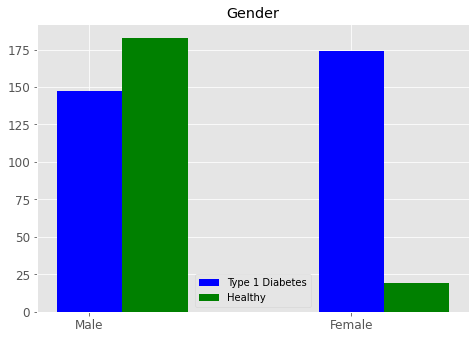

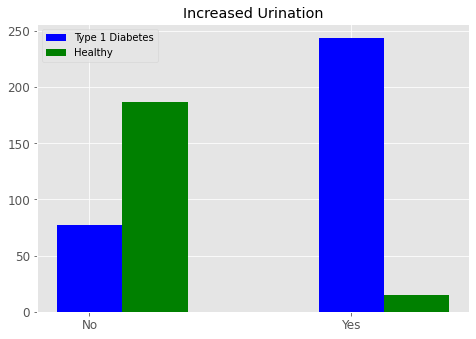

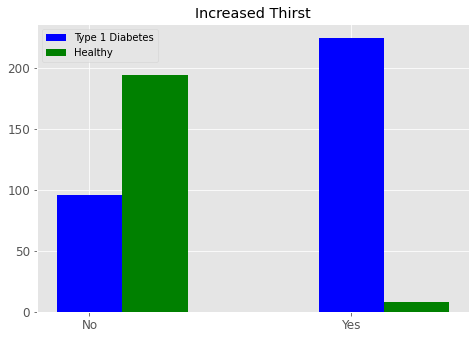

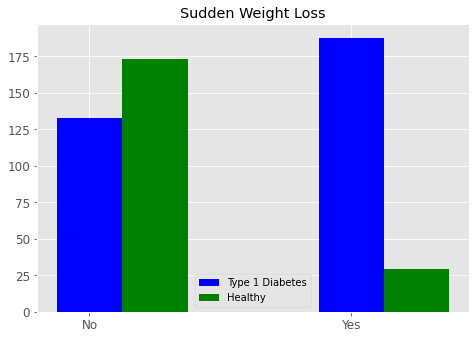

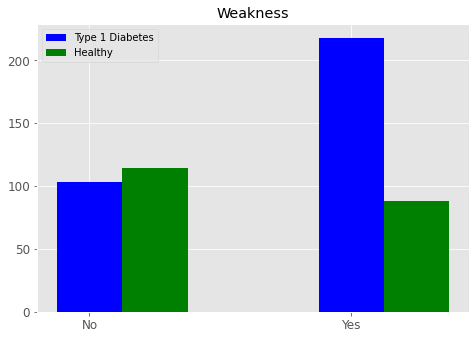

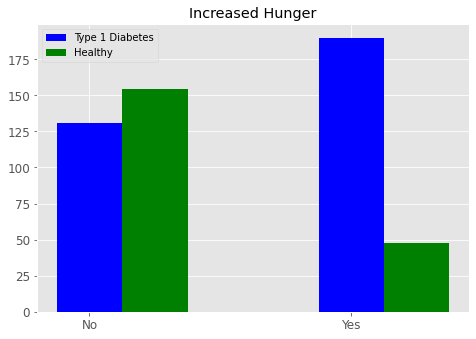

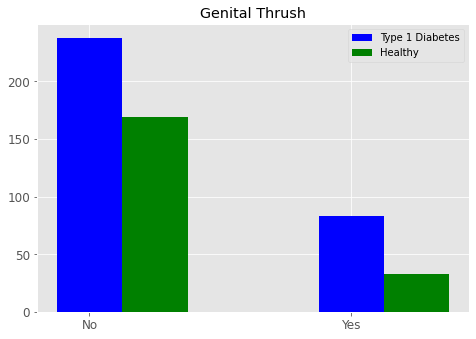

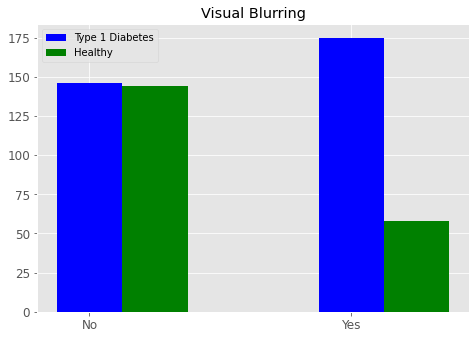

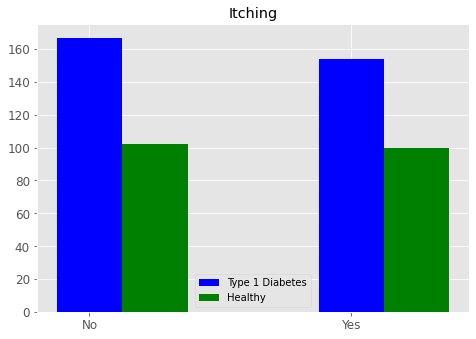

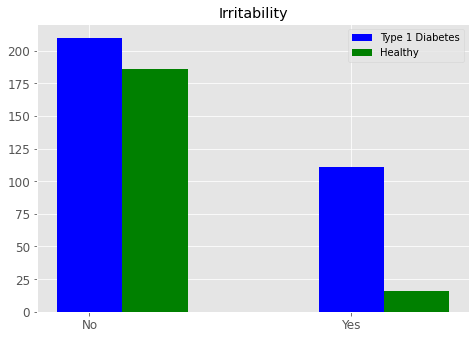

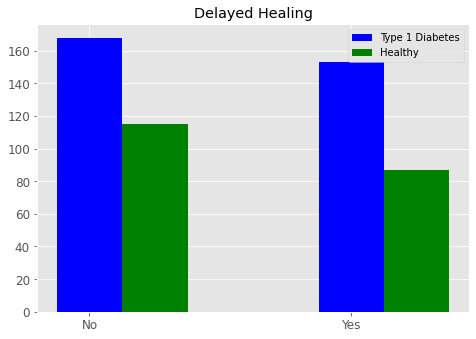

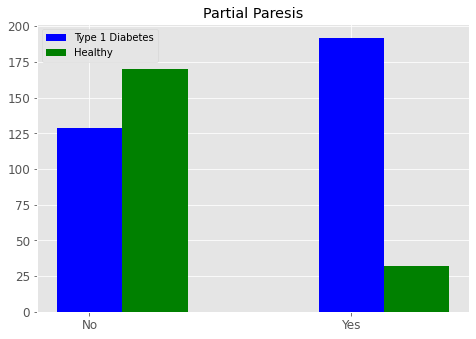

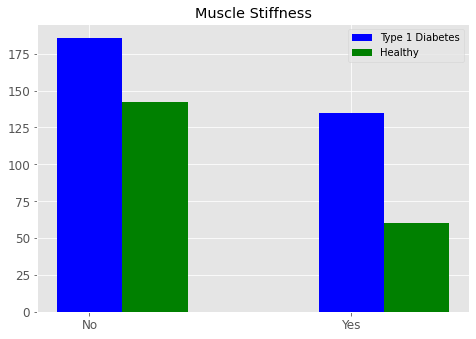

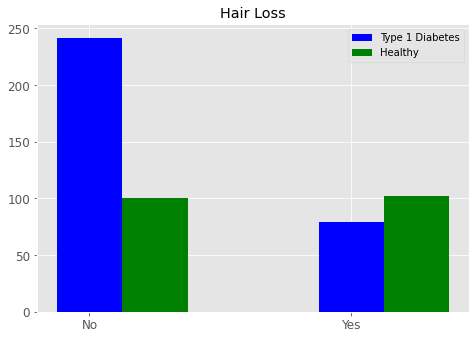

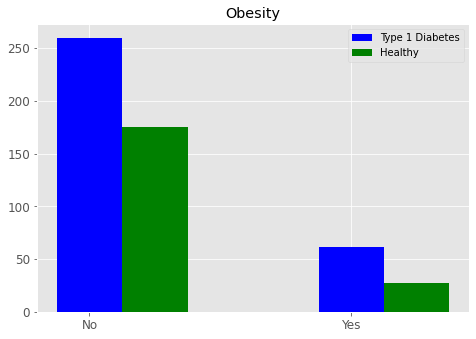

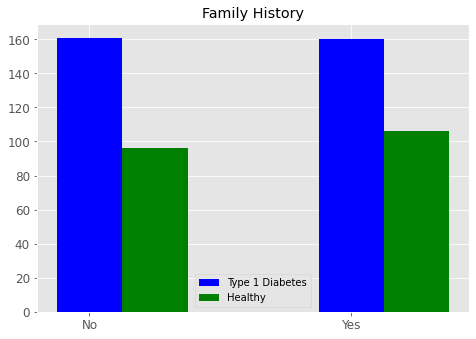

In [20]:
X_t1d = X[Y == 1]
X_norm = X[Y == 0]

for i, feat in enumerate(features[1:]):
    neg_t1d, pos_t1d = count(X_t1d, feat)
    neg_norm, pos_norm = count(X_norm, feat)
    fig = plt.figure(i)
    ax = fig.add_axes([0, 0, 1, 1])
    x = np.arange(2, step=1)
    ax.bar(x, [neg_t1d, pos_t1d], color='b', width=0.25)
    ax.bar(x + 0.25, [neg_norm, pos_norm], color='g', width=0.25)
    ax.legend(labels=['Type 1 Diabetes', 'Healthy'])
    ax.set_title(feat)
    if feat == 'Gender':
        plt.xticks(x, ('Male', 'Female'))
    else:
        plt.xticks(x, ('No', 'Yes'))
    plt.show()

Text(0.5, 1.0, 'Age Histogram Correlation To Type 1 Diabetes Diagnosis')

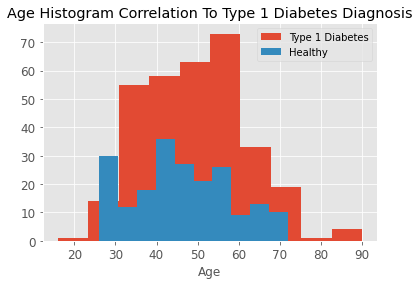

In [21]:
fig, ax = plt.subplots(1, 1)
X_t1d['Age'].hist(label='Type 1 Diabetes', ax=ax)
X_norm['Age'].hist(label='Healthy', ax=ax)
ax.legend(['Type 1 Diabetes', 'Healthy'])
ax.set_xlabel('Age')
ax.set_title('Age Histogram Correlation To Type 1 Diabetes Diagnosis')

##### Q3.c
Additional plot that make sense given the mostly binary nature of this dataset

Graphs to show the distribution of the data in test set and training set:

Train


<AxesSubplot:ylabel='Diagnosis'>

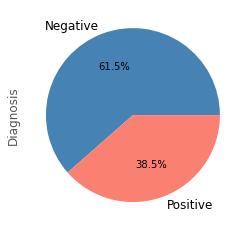

In [22]:
print('Train')
Y_train.value_counts().plot(kind='pie', labels=['Negative', 'Positive'], colors=['steelblue', 'salmon'], autopct='%1.1f%%')

Test


<AxesSubplot:ylabel='Diagnosis'>

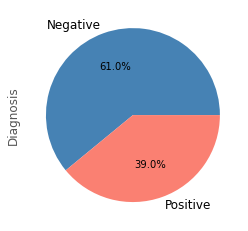

In [23]:
print('Test')
Y_test.value_counts().plot(kind='pie', labels=['Negative', 'Positive'], colors=['steelblue', 'salmon'], autopct='%1.1f%%')

Heat Map to show corrolation between features:

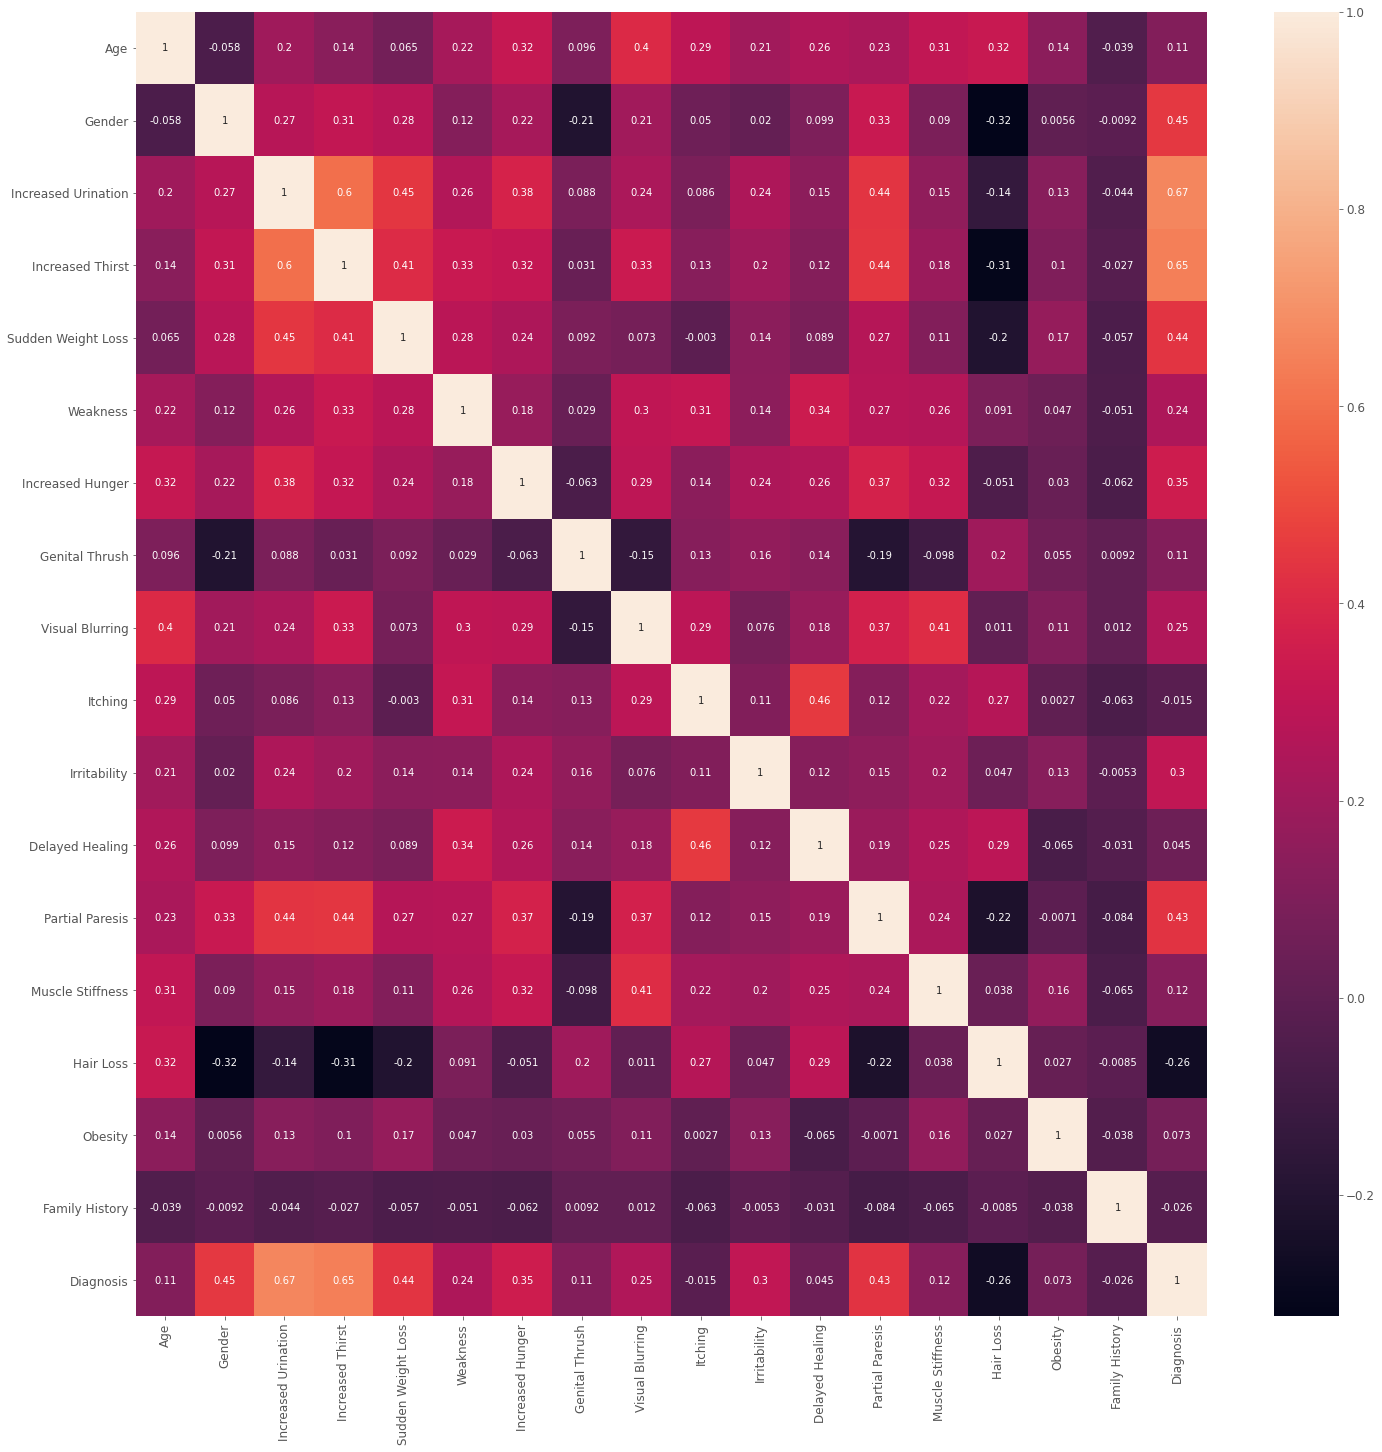

In [24]:
plt.figure(figsize = (24,24))
sns.heatmap(X.join(Y).corr(), annot = True)
plt.show()

##### Q3.d
State any insights gained, reference to unexpected findings and  features that can be particularly important to the model.

answer:

Based on the graphs and heat map shown above, we can identify features that are highly correlated with the medical diagnosis. such features are: 'Gender', 'Increased Uritation', 'Increased Thirst' and 'Sudden Weight Loss'. this features may be very imported for the model.
We may notice unexpected values, for example most females seem to be diagnosed as positive compared to males, a result we did not expect based on our existing knowledge about the disease.
In addition, we note that for the ‘Hair Loss’ feature it is obtained that most of those who reported ‘No’ in the questionnaire are actually diagnosed as positive, even though hair loss is one of the first symptoms of the disease.



#### Q4
Encoding the train and test sets as one hot vectors

In [25]:
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False)
X_train_hv = one_hot_encoder.fit_transform(X_train)
X_test_hv = one_hot_encoder.transform(X_test)

print(X_train_hv)
print(X_test_hv)
print(X_train_hv.shape)
print(X_test_hv.shape)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[[0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(418, 83)
(105, 83)


#### Q5 
Training Classifications models.

The following steps are trying different models (linear and non-linear), using 5-cross fold validation, and reporting evaluation metrics.

Functions for evaluation

In [26]:
calc_TN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 0]
calc_FP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 1]
calc_FN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 0]
calc_TP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 1]

def evaluation_metrics(Y_test, Y_pred):
    TN = calc_TN(Y_test, y_pred)
    FP = calc_FP(Y_test, y_pred)
    FN = calc_FN(Y_test, y_pred)
    TP = calc_TP(Y_test, y_pred)
    Se = TP/(TP+FN)
    Sp = TN/(TN+FP)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    Acc = (TP+TN)/(TP+TN+FP+FN)
    F1 = (2*Se*PPV)/(Se+PPV)
    
    return Se, Sp, PPV, NPV, Acc, F1

#### Naive Classifier

In [27]:
print('The naive classifier achieved an accuracy of %.2f%%.' % (100 * Y_test.value_counts()[1]/len(Y_test)))

The naive classifier achieved an accuracy of 60.95%.


#### Logistic Regression

We will use K-Fold Cross Validation to tune lambda For Logistic Regression

In [28]:
solver = 'lbfgs'
scaler = StandardScaler()
max_iter = 200
n_splits = 5
penalty = ['l2']
log_reg = LogisticRegression(random_state=5, max_iter=max_iter,solver=solver)
lmbda = np.array([0.01, 0.01, 1, 10, 100, 1000])

skf = StratifiedKFold(n_splits = n_splits, random_state=42, shuffle=True)

pipe = Pipeline(steps=[('scale', scaler), ('logistic', log_reg)])
log_lin = GridSearchCV(estimator=pipe, param_grid={'logistic__C': 1/lmbda, 'logistic__penalty': penalty},
                   scoring=['accuracy','f1','precision','recall','roc_auc'], cv=skf,
                   refit='roc_auc', verbose=3, return_train_score=True)
log_lin.fit(X_train_hv, Y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] logistic__C=100.0, logistic__penalty=l2 .........................
[CV]  logistic__C=100.0, logistic__penalty=l2, accuracy=(train=0.991, test=0.869), f1=(train=0.993, test=0.897), precision=(train=0.995, test=0.873), recall=(train=0.990, test=0.923), roc_auc=(train=1.000, test=0.966), total=   0.1s
[CV] logistic__C=100.0, logistic__penalty=l2 .........................
[CV]  logistic__C=100.0, logistic__penalty=l2, accuracy=(train=1.000, test=0.952), f1=(train=1.000, test=0.961), precision=(train=1.000, test=0.980), recall=(train=1.000, test=0.942), roc_auc=(train=1.000, test=0.962), total=   0.1s
[CV] logistic__C=100.0, logistic__penalty=l2 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  logistic__C=100.0, logistic__penalty=l2, accuracy=(train=1.000, test=0.929), f1=(train=1.000, test=0.941), precision=(train=1.000, test=0.941), recall=(train=1.000, test=0.941), roc_auc=(train=1.000, test=0.954), total=   0.1s
[CV] logistic__C=100.0, logistic__penalty=l2 .........................
[CV]  logistic__C=100.0, logistic__penalty=l2, accuracy=(train=1.000, test=0.916), f1=(train=1.000, test=0.931), precision=(train=1.000, test=0.940), recall=(train=1.000, test=0.922), roc_auc=(train=1.000, test=0.955), total=   0.1s
[CV] logistic__C=100.0, logistic__penalty=l2 .........................
[CV]  logistic__C=100.0, logistic__penalty=l2, accuracy=(train=1.000, test=0.904), f1=(train=1.000, test=0.920), precision=(train=1.000, test=0.939), recall=(train=1.000, test=0.902), roc_auc=(train=1.000, test=0.939), total=   0.1s
[CV] logistic__C=100.0, logistic__penalty=l2 .........................
[CV]  logistic__C=100.0, logistic__penalty=l2, accuracy=(train=0.991, test=0.869), f1=(t

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(max_iter=200,
                                                           random_state=5))]),
             param_grid={'logistic__C': array([1.e+02, 1.e+02, 1.e+00, 1.e-01, 1.e-02, 1.e-03]),
                         'logistic__penalty': ['l2']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

Take the best estimator based on the cross validation:

In [29]:
best_log_reg = log_lin.best_estimator_
print(log_lin.best_params_)

{'logistic__C': 0.1, 'logistic__penalty': 'l2'}


Implementation and evaluation of the model:

Sensitivity is 0.94 
Specificity is 0.98 
PPV is 0.98 
NPV is 0.91 
Accuracy is 0.95 
F1 is 0.96 
AUROC is 0.978


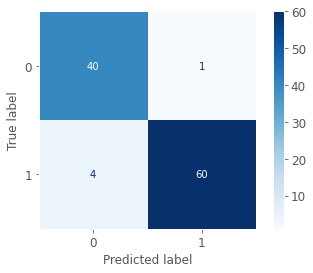

In [31]:
y_pred = best_log_reg.predict(X_test_hv)
y_pred_proba = best_log_reg.predict_proba(X_test_hv)

plot_confusion_matrix(best_log_reg, X_test_hv, Y_test, cmap=plt.cm.Blues)
plt.grid(False)

print('Sensitivity is {:.2f} \nSpecificity is {:.2f} \nPPV is {:.2f} \nNPV is {:.2f} \nAccuracy is {:.2f} \nF1 is {:.2f} '.format(*evaluation_metrics(Y_test, y_pred)))

print('AUROC is {:.3f}'.format(roc_auc_score(Y_test, y_pred_proba[:,1])))

#### Linear SVM

In [32]:
svc = SVC(probability=True)
C = np.array([0.001, 0.01, 1, 10, 100, 1000])

pipe = Pipeline(steps=[('scale', scaler), ('svm', svc)])
svm_lin = GridSearchCV(estimator=pipe,
             param_grid={'svm__kernel':['linear'], 'svm__C':C},
             scoring=['accuracy','f1','precision','recall','roc_auc'], 
             cv=skf, refit='roc_auc', verbose=3, return_train_score=True)
svm_lin.fit(X_train_hv, Y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] svm__C=0.001, svm__kernel=linear ................................
[CV]  svm__C=0.001, svm__kernel=linear, accuracy=(train=0.892, test=0.893), f1=(train=0.908, test=0.907), precision=(train=0.957, test=0.978), recall=(train=0.863, test=0.846), roc_auc=(train=0.974, test=0.961), total=   0.0s
[CV] svm__C=0.001, svm__kernel=linear ................................
[CV]  svm__C=0.001, svm__kernel=linear, accuracy=(train=0.889, test=0.893), f1=(train=0.904, test=0.905), precision=(train=0.962, test=1.000), recall=(train=0.854, test=0.827), roc_auc=(train=0.969, test=0.960), total=   0.0s
[CV] svm__C=0.001, svm__kernel=linear ................................
[CV]  svm__C=0.001, svm__kernel=linear, accuracy=(train=0.913, test=0.929), f1=(train=0.927, test=0.940), precision=(train=0.968, test=0.959), recall=(train=0.888, test=0.922), roc_auc=(train=0.974, test=0.964), total=   0.0s
[CV] svm__C=0.001, svm__kernel=linear ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  svm__C=0.001, svm__kernel=linear, accuracy=(train=0.899, test=0.867), f1=(train=0.913, test=0.889), precision=(train=0.967, test=0.917), recall=(train=0.864, test=0.863), roc_auc=(train=0.975, test=0.955), total=   0.0s
[CV] svm__C=0.001, svm__kernel=linear ................................
[CV]  svm__C=0.001, svm__kernel=linear, accuracy=(train=0.910, test=0.831), f1=(train=0.923, test=0.854), precision=(train=0.973, test=0.911), recall=(train=0.879, test=0.804), roc_auc=(train=0.976, test=0.949), total=   0.0s
[CV] svm__C=0.01, svm__kernel=linear .................................
[CV]  svm__C=0.01, svm__kernel=linear, accuracy=(train=0.928, test=0.917), f1=(train=0.941, test=0.932), precision=(train=0.941, test=0.941), recall=(train=0.941, test=0.923), roc_auc=(train=0.977, test=0.955), total=   0.0s
[CV] svm__C=0.01, svm__kernel=linear .................................
[CV]  svm__C=0.01, svm__kernel=linear, accuracy=(train=0.937, test=0.893), f1=(train=0.949, test=0.909), preci

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('svm', SVC(probability=True))]),
             param_grid={'svm__C': array([1.e-03, 1.e-02, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'svm__kernel': ['linear']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

Take the best estimator based on the cross validation:

In [33]:
best_svm_lin = svm_lin.best_estimator_
print(svm_lin.best_params_)

{'svm__C': 1.0, 'svm__kernel': 'linear'}


Implementation and evaluation of the model:

Sensitivity is 0.95 
Specificity is 0.95 
PPV is 0.97 
NPV is 0.93 
Accuracy is 0.95 
F1 is 0.96 
AUROC is 0.975


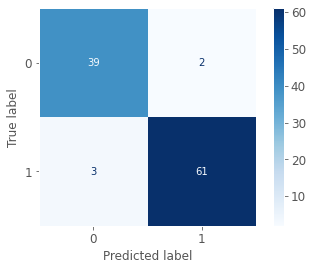

In [34]:
y_pred = best_svm_lin.predict(X_test_hv)
y_pred_proba = best_svm_lin.predict_proba(X_test_hv)

plot_confusion_matrix(best_svm_lin, X_test_hv, Y_test, cmap=plt.cm.Blues)
plt.grid(False)

print('Sensitivity is {:.2f} \nSpecificity is {:.2f} \nPPV is {:.2f} \nNPV is {:.2f} \nAccuracy is {:.2f} \nF1 is {:.2f} '.format(*evaluation_metrics(Y_test, y_pred)))

print('AUROC is {:.3f}'.format(roc_auc_score(Y_test, y_pred_proba[:,1])))

#### Non-linear SVM

In [35]:
svm_nonlin = GridSearchCV(estimator=pipe,
             param_grid={'svm__kernel':['rbf','poly'], 'svm__C':C, 'svm__degree':[3], 'svm__gamma':['auto','scale']},
             scoring=['accuracy','f1','precision','recall','roc_auc'], 
             cv=skf, refit='roc_auc', verbose=3, return_train_score=True)
svm_nonlin.fit(X_train_hv, Y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf ...
[CV]  svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.614, test=0.619), f1=(train=0.761, test=0.765), precision=(train=0.614, test=0.619), recall=(train=1.000, test=1.000), roc_auc=(train=0.979, test=0.971), total=   0.1s
[CV] svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf ...
[CV]  svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.614, test=0.619), f1=(train=0.761, test=0.765), precision=(train=0.614, test=0.619), recall=(train=1.000, test=1.000), roc_auc=(train=0.970, test=0.961), total=   0.1s
[CV] svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.617, test=0.607), f1=(train=0.763, test=0.756), precision=(train=0.617, test=0.607), recall=(train=1.000, test=1.000), roc_auc=(train=0.972, test=0.922), total=   0.1s
[CV] svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf ...
[CV]  svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.615, test=0.614), f1=(train=0.762, test=0.761), precision=(train=0.615, test=0.614), recall=(train=1.000, test=1.000), roc_auc=(train=0.976, test=0.938), total=   0.1s
[CV] svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf ...
[CV]  svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.615, test=0.614), f1=(train=0.762, test=0.761), precision=(train=0.615, test=0.614), recall=(train=1.000, test=1.000), roc_auc=(train=0.976, test=0.908), total=   0.1s
[CV] svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=poly ..
[CV]  svm__C=0.001, sv

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    7.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('svm', SVC(probability=True))]),
             param_grid={'svm__C': array([1.e-03, 1.e-02, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'svm__degree': [3], 'svm__gamma': ['auto', 'scale'],
                         'svm__kernel': ['rbf', 'poly']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

Take the best estimator based on the cross validation:

In [36]:
best_svm_nonlin = svm_nonlin.best_estimator_
print(svm_nonlin.best_params_)

{'svm__C': 10.0, 'svm__degree': 3, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}


Implementation and evaluation of the model:

Sensitivity is 0.97. 
Specificity is 1.00. 
PPV is 1.00. 
NPV is 0.95. 
Accuracy is 0.98. 
F1 is 0.98. 
AUROC is 0.998


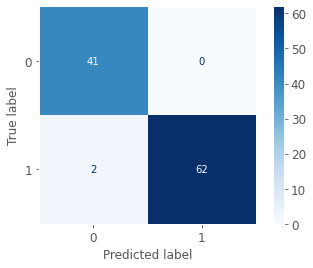

In [38]:
y_pred = best_svm_nonlin.predict(X_test_hv)
y_pred_proba = best_svm_nonlin.predict_proba(X_test_hv)

plot_confusion_matrix(best_svm_nonlin, X_test_hv, Y_test, cmap=plt.cm.Blues)
plt.grid(False)

print('Sensitivity is {:.2f}. \nSpecificity is {:.2f}. \nPPV is {:.2f}. \nNPV is {:.2f}. \nAccuracy is {:.2f}. \nF1 is {:.2f}. '.format(*evaluation_metrics(Y_test, y_pred)))

print('AUROC is {:.3f}'.format(roc_auc_score(Y_test, y_pred_proba[:,1])))

#### Summary Of Classifiers

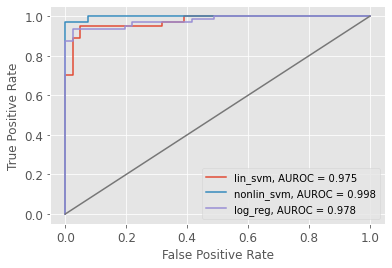

In [42]:
classifiers = [best_svm_lin, best_svm_nonlin, best_log_reg]
roc_score = []
plt.figure()
ax = plt.gca()
for clf in classifiers:
    plot_roc_curve(clf, X_test_hv, Y_test, ax=ax)
    roc_score.append(np.round_(roc_auc_score(Y_test, clf.predict_proba(X_test_hv)[:,1]), decimals=3))
ax.plot(np.linspace(0,1,X_test_hv.shape[0]),np.linspace(0,1,X_test_hv.shape[0]))
plt.legend(('lin_svm, AUROC = '+str(roc_score[0]),'nonlin_svm, AUROC = '+str(roc_score[1]),'log_reg, AUROC = '+str(roc_score[2])))

##### Q5.c.

Based on the Area Under the Curve (AUC), the classifier that performed best is Non-linear SVM.

#### Q6
Random Forest Classifier

We chose to run the Random Forest model on the original data. By one-hot encoding a categorical variable, we are inducing sparsity into the dataset which is undesirable.

Sensitivity is 0.92. 
Specificity is 0.98. 
PPV is 0.98. 
NPV is 0.89. 
Accuracy is 0.94. 
F1 is 0.95. 
AUROC is 0.995


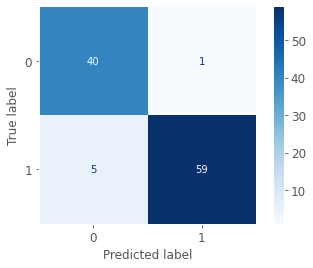

In [56]:
rfc = Pipeline(steps=[('scale', scaler), ('rfc', RandomForestClassifier(max_depth=4, random_state=42, criterion='gini'))])
rfc.fit(X_train, Y_train)

y_pred = rfc.predict(X_test) 
y_pred_proba = rfc.predict_proba(X_test)

plot_confusion_matrix(rfc, X_test, Y_test, cmap=plt.cm.Blues)
plt.grid(False)

print('Sensitivity is {:.2f}. \nSpecificity is {:.2f}. \nPPV is {:.2f}. \nNPV is {:.2f}. \nAccuracy is {:.2f}. \nF1 is {:.2f}. '.format(*evaluation_metrics(Y_test, y_pred)))

print('AUROC is {:.3f}'.format(roc_auc_score(Y_test, y_pred_proba[:,1])))

Feature Selection using Random Forest:

In [57]:
importance = rfc.steps[1][1].feature_importances_

for i, v in enumerate(importance):
    print('Feature: % 20s, Score: %.5f' % (keys[i], v))

Feature:                  Age, Score: 0.05046
Feature:               Gender, Score: 0.12230
Feature:  Increased Urination, Score: 0.33399
Feature:     Increased Thirst, Score: 0.19778
Feature:   Sudden Weight Loss, Score: 0.05327
Feature:             Weakness, Score: 0.00966
Feature:     Increased Hunger, Score: 0.03797
Feature:       Genital Thrush, Score: 0.01569
Feature:      Visual Blurring, Score: 0.01869
Feature:              Itching, Score: 0.01182
Feature:         Irritability, Score: 0.04244
Feature:      Delayed Healing, Score: 0.01144
Feature:      Partial Paresis, Score: 0.05235
Feature:     Muscle Stiffness, Score: 0.01384
Feature:            Hair Loss, Score: 0.01893
Feature:              Obesity, Score: 0.00720
Feature:       Family History, Score: 0.00217


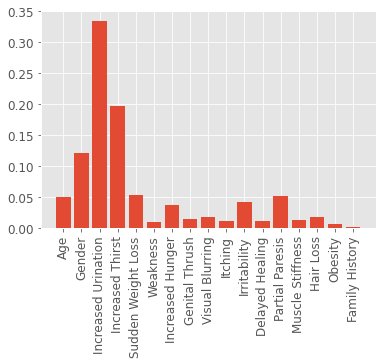

In [63]:
ax = plt.bar([keys[i] for i in range(len(importance))], importance)
plt.xticks(rotation=90)
plt.show()

Note that the sum of the importance of all the features is 1 as we expected.
The 2 most important features according to the random forest are increased urination and increased thirst.

This matches the feature exploration we did.

#### Q7
Data Separability Visualization

##### Q7.a
We will use PCA for dimensionality reduction.

In [66]:
def plt_2d_pca(X_pca,y):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, aspect='equal')
    ax.scatter(X_pca[y==0, 0], X_pca[y==0, 1], color='b')
    ax.scatter(X_pca[y==1, 0], X_pca[y==1, 1], color='r')
    ax.legend(('Healty','T1D'))
    ax.plot([0], [0], "ko")
    ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
    ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
    ax.set_xlabel('$U_1$')
    ax.set_ylabel('$U_2$')
    ax.set_title('2D PCA')

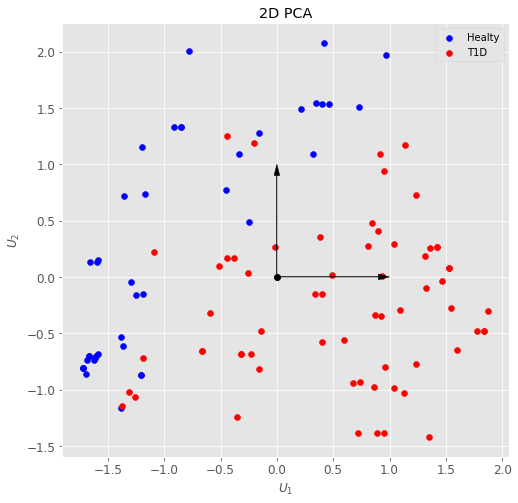

In [77]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_components = 2
pca = PCA(n_components=n_components, whiten=True)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

plt_2d_pca(X_test_pca[:,0:2],Y_test)

##### Q7.b
Based on the two-dimensional graph obtained, it can be seen that the data can be separated. The data can be separated linearly if a relatively small number of mismatches.

##### Q7.c

Training the models from Q5 on the dimensionality training set (2 components):

#### Logistic Regression

In [78]:
log_lin.fit(X_train_pca,Y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] logistic__C=100.0, logistic__penalty=l2 .........................
[CV]  logistic__C=100.0, logistic__penalty=l2, accuracy=(train=0.838, test=0.845), f1=(train=0.867, test=0.874), precision=(train=0.876, test=0.882), recall=(train=0.859, test=0.865), roc_auc=(train=0.927, test=0.928), total=   0.0s
[CV] logistic__C=100.0, logistic__penalty=l2 .........................
[CV]  logistic__C=100.0, logistic__penalty=l2, accuracy=(train=0.826, test=0.845), f1=(train=0.859, test=0.879), precision=(train=0.859, test=0.855), recall=(train=0.859, test=0.904), roc_auc=(train=0.925, test=0.934), total=   0.0s
[CV] logistic__C=100.0, logistic__penalty=l2 .........................
[CV]  logistic__C=100.0, logistic__penalty=l2, accuracy=(train=0.847, test=0.821), f1=(train=0.875, test=0.848), precision=(train=0.882, test=0.875), recall=(train=0.869, test=0.824), roc_auc=(train=0.927, test=0.928), total=   0.0s
[CV] logistic__C=100.0, logi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  logistic__C=1.0, logistic__penalty=l2, accuracy=(train=0.826, test=0.845), f1=(train=0.859, test=0.879), precision=(train=0.859, test=0.855), recall=(train=0.859, test=0.904), roc_auc=(train=0.925, test=0.934), total=   0.0s
[CV] logistic__C=1.0, logistic__penalty=l2 ...........................
[CV]  logistic__C=1.0, logistic__penalty=l2, accuracy=(train=0.847, test=0.821), f1=(train=0.875, test=0.848), precision=(train=0.882, test=0.875), recall=(train=0.869, test=0.824), roc_auc=(train=0.927, test=0.927), total=   0.0s
[CV] logistic__C=1.0, logistic__penalty=l2 ...........................
[CV]  logistic__C=1.0, logistic__penalty=l2, accuracy=(train=0.815, test=0.916), f1=(train=0.850, test=0.931), precision=(train=0.846, test=0.940), recall=(train=0.854, test=0.922), roc_auc=(train=0.919, test=0.945), total=   0.0s
[CV] logistic__C=1.0, logistic__penalty=l2 ...........................
[CV]  logistic__C=1.0, logistic__penalty=l2, accuracy=(train=0.860, test=0.735), f1=(train=0.8

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(max_iter=200,
                                                           random_state=5))]),
             param_grid={'logistic__C': array([1.e+02, 1.e+02, 1.e+00, 1.e-01, 1.e-02, 1.e-03]),
                         'logistic__penalty': ['l2']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

In [79]:
best_log_reg = log_lin.best_estimator_
y_pred = best_log_reg.predict(X_test_pca)
y_pred_proba = best_log_reg.predict_proba(X_test_pca)

print('Sensitivity is {:.2f} \nSpecificity is {:.2f} \nPPV is {:.2f} \nNPV is {:.2f} \nAccuracy is {:.2f} \nF1 is {:.2f} '.format(*evaluation_metrics(Y_test, y_pred)))

print('AUROC is {:.3f}'.format(roc_auc_score(Y_test, y_pred_proba[:,1])))

Sensitivity is 0.86 
Specificity is 0.88 
PPV is 0.92 
NPV is 0.80 
Accuracy is 0.87 
F1 is 0.89 
AUROC is 0.952


#### Linear SVM

In [80]:
svm_lin.fit(X_train_pca,Y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] svm__C=0.001, svm__kernel=linear ................................
[CV]  svm__C=0.001, svm__kernel=linear, accuracy=(train=0.614, test=0.619), f1=(train=0.761, test=0.765), precision=(train=0.614, test=0.619), recall=(train=1.000, test=1.000), roc_auc=(train=0.924, test=0.930), total=   0.0s
[CV] svm__C=0.001, svm__kernel=linear ................................
[CV]  svm__C=0.001, svm__kernel=linear, accuracy=(train=0.614, test=0.619), f1=(train=0.761, test=0.765), precision=(train=0.614, test=0.619), recall=(train=1.000, test=1.000), roc_auc=(train=0.919, test=0.921), total=   0.0s
[CV] svm__C=0.001, svm__kernel=linear ................................
[CV]  svm__C=0.001, svm__kernel=linear, accuracy=(train=0.617, test=0.607), f1=(train=0.763, test=0.756), precision=(train=0.617, test=0.607), recall=(train=1.000, test=1.000), roc_auc=(train=0.924, test=0.928), total=   0.0s
[CV] svm__C=0.001, svm__kernel=linear ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  svm__C=1.0, svm__kernel=linear, accuracy=(train=0.853, test=0.833), f1=(train=0.880, test=0.857), precision=(train=0.891, test=0.894), recall=(train=0.869, test=0.824), roc_auc=(train=0.928, test=0.926), total=   0.0s
[CV] svm__C=1.0, svm__kernel=linear ..................................
[CV]  svm__C=1.0, svm__kernel=linear, accuracy=(train=0.824, test=0.916), f1=(train=0.855, test=0.931), precision=(train=0.866, test=0.940), recall=(train=0.845, test=0.922), roc_auc=(train=0.920, test=0.947), total=   0.0s
[CV] svm__C=1.0, svm__kernel=linear ..................................
[CV]  svm__C=1.0, svm__kernel=linear, accuracy=(train=0.863, test=0.783), f1=(train=0.887, test=0.816), precision=(train=0.900, test=0.851), recall=(train=0.874, test=0.784), roc_auc=(train=0.934, test=0.890), total=   0.0s
[CV] svm__C=10.0, svm__kernel=linear .................................
[CV]  svm__C=10.0, svm__kernel=linear, accuracy=(train=0.847, test=0.845), f1=(train=0.873, test=0.874), precision=

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('svm', SVC(probability=True))]),
             param_grid={'svm__C': array([1.e-03, 1.e-02, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'svm__kernel': ['linear']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

In [81]:
best_svm_lin = svm_lin.best_estimator_
y_pred = best_svm_lin.predict(X_test_pca)
y_pred_proba = best_svm_lin.predict_proba(X_test_pca)

print('Sensitivity is {:.2f} \nSpecificity is {:.2f} \nPPV is {:.2f} \nNPV is {:.2f} \nAccuracy is {:.2f} \nF1 is {:.2f} '.format(*evaluation_metrics(Y_test, y_pred)))

print('AUROC is {:.3f}'.format(roc_auc_score(Y_test, y_pred_proba[:,1])))

Sensitivity is 0.86 
Specificity is 0.93 
PPV is 0.95 
NPV is 0.81 
Accuracy is 0.89 
F1 is 0.90 
AUROC is 0.957


#### Non-Linear SVM

In [82]:
svm_nonlin.fit(X_train_pca,Y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf ...
[CV]  svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.614, test=0.619), f1=(train=0.761, test=0.765), precision=(train=0.614, test=0.619), recall=(train=1.000, test=1.000), roc_auc=(train=0.932, test=0.938), total=   0.0s
[CV] svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf ...
[CV]  svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.614, test=0.619), f1=(train=0.761, test=0.765), precision=(train=0.614, test=0.619), recall=(train=1.000, test=1.000), roc_auc=(train=0.932, test=0.936), total=   0.0s
[CV] svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf ...
[CV]  svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.617, test=0.607), f1=(train=0.763, test=0.756), precision=(train=0.617, test=0.607), recall=(train=1.000, test=1.000), roc_auc=(

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=poly, accuracy=(train=0.615, test=0.614), f1=(train=0.762, test=0.761), precision=(train=0.615, test=0.614), recall=(train=1.000, test=1.000), roc_auc=(train=0.951, test=0.950), total=   0.0s
[CV] svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=poly ..
[CV]  svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=poly, accuracy=(train=0.615, test=0.614), f1=(train=0.762, test=0.761), precision=(train=0.615, test=0.614), recall=(train=1.000, test=1.000), roc_auc=(train=0.956, test=0.924), total=   0.0s
[CV] svm__C=0.001, svm__degree=3, svm__gamma=scale, svm__kernel=rbf ..
[CV]  svm__C=0.001, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, accuracy=(train=0.614, test=0.619), f1=(train=0.761, test=0.765), precision=(train=0.614, test=0.619), recall=(train=1.000, test=1.000), roc_auc=(train=0.932, test=0.938), total=   0.0s
[CV] svm__C=0.001, svm__degree=3, svm__gamma=scale, svm__kernel=rbf ..
[CV]  svm__C=0.001,

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    4.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('svm', SVC(probability=True))]),
             param_grid={'svm__C': array([1.e-03, 1.e-02, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'svm__degree': [3], 'svm__gamma': ['auto', 'scale'],
                         'svm__kernel': ['rbf', 'poly']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

In [83]:
best_svm_nonlin = svm_nonlin.best_estimator_
y_pred = best_svm_nonlin.predict(X_test_pca)
y_pred_proba = best_svm_nonlin.predict_proba(X_test_pca)

print('Sensitivity is {:.2f} \nSpecificity is {:.2f} \nPPV is {:.2f} \nNPV is {:.2f} \nAccuracy is {:.2f} \nF1 is {:.2f} '.format(*evaluation_metrics(Y_test, y_pred)))

print('AUROC is {:.3f}'.format(roc_auc_score(Y_test, y_pred_proba[:,1])))

Sensitivity is 0.88 
Specificity is 0.88 
PPV is 0.92 
NPV is 0.82 
Accuracy is 0.88 
F1 is 0.90 
AUROC is 0.947


##### Q7.d

The 2 most important features based on Q6 are increased urination and increased thirst.
Training the models from Q5 on these 2 features only:

In [105]:
feat_name = ['Increased Urination','Increased Thirst']
X2d = dataset[feat_name]
X2d = X2d.values
Y2 = dataset['Diagnosis']
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2d, Y2, test_size=0.1, stratify=Y2, random_state=42)

#### Logistic Regression

In [107]:
log_lin.fit(X2_train,Y2_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] logistic__C=100.0, logistic__penalty=l2 .........................
[CV]  logistic__C=100.0, logistic__penalty=l2, accuracy=(train=0.859, test=0.894), f1=(train=0.880, test=0.911), precision=(train=0.915, test=0.944), recall=(train=0.848, test=0.879), roc_auc=(train=0.899, test=0.924), total=   0.0s
[CV] logistic__C=100.0, logistic__penalty=l2 .........................
[CV]  logistic__C=100.0, logistic__penalty=l2, accuracy=(train=0.875, test=0.830), f1=(train=0.895, test=0.849), precision=(train=0.918, test=0.938), recall=(train=0.874, test=0.776), roc_auc=(train=0.915, test=0.864), total=   0.0s
[CV] logistic__C=100.0, logistic__penalty=l2 .........................
[CV]  logistic__C=100.0, logistic__penalty=l2, accuracy=(train=0.864, test=0.872), f1=(train=0.884, test=0.895), precision=(train=0.924, test=0.911), recall=(train=0.848, test=0.879), roc_auc=(train=0.903, test=0.903), total=   0.0s
[CV] logistic__C=100.0, logi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  logistic__C=1.0, logistic__penalty=l2, accuracy=(train=0.864, test=0.872), f1=(train=0.884, test=0.895), precision=(train=0.924, test=0.911), recall=(train=0.848, test=0.879), roc_auc=(train=0.903, test=0.903), total=   0.0s
[CV] logistic__C=1.0, logistic__penalty=l2 ...........................
[CV]  logistic__C=1.0, logistic__penalty=l2, accuracy=(train=0.862, test=0.883), f1=(train=0.883, test=0.901), precision=(train=0.920, test=0.926), recall=(train=0.848, test=0.877), roc_auc=(train=0.900, test=0.919), total=   0.0s
[CV] logistic__C=1.0, logistic__penalty=l2 ...........................
[CV]  logistic__C=1.0, logistic__penalty=l2, accuracy=(train=0.870, test=0.851), f1=(train=0.889, test=0.875), precision=(train=0.929, test=0.891), recall=(train=0.853, test=0.860), roc_auc=(train=0.907, test=0.890), total=   0.0s
[CV] logistic__C=0.1, logistic__penalty=l2 ...........................
[CV]  logistic__C=0.1, logistic__penalty=l2, accuracy=(train=0.859, test=0.894), f1=(train=0.8

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(max_iter=200,
                                                           random_state=5))]),
             param_grid={'logistic__C': array([1.e+02, 1.e+02, 1.e+00, 1.e-01, 1.e-02, 1.e-03]),
                         'logistic__penalty': ['l2']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

In [108]:
best_log_reg = log_lin.best_estimator_
y_pred = best_log_reg.predict(X2_test)
y_pred_proba = best_log_reg.predict_proba(X2_test)

print('Sensitivity is {:.2f} \nSpecificity is {:.2f} \nPPV is {:.2f} \nNPV is {:.2f} \nAccuracy is {:.2f} \nF1 is {:.2f} '.format(*evaluation_metrics(Y2_test, y_pred)))

print('AUROC is {:.3f}'.format(roc_auc_score(Y2_test, y_pred_proba[:,1])))

Sensitivity is 0.91 
Specificity is 0.90 
PPV is 0.94 
NPV is 0.86 
Accuracy is 0.91 
F1 is 0.92 
AUROC is 0.927


#### Linear SVM

In [109]:
svm_lin.fit(X2_train,Y2_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] svm__C=0.001, svm__kernel=linear ................................
[CV]  svm__C=0.001, svm__kernel=linear, accuracy=(train=0.612, test=0.617), f1=(train=0.759, test=0.763), precision=(train=0.612, test=0.617), recall=(train=1.000, test=1.000), roc_auc=(train=0.897, test=0.929), total=   0.0s
[CV] svm__C=0.001, svm__kernel=linear ................................
[CV]  svm__C=0.001, svm__kernel=linear, accuracy=(train=0.612, test=0.617), f1=(train=0.759, test=0.763), precision=(train=0.612, test=0.617), recall=(train=1.000, test=1.000), roc_auc=(train=0.915, test=0.864), total=   0.0s
[CV] svm__C=0.001, svm__kernel=linear ................................
[CV]  svm__C=0.001, svm__kernel=linear, accuracy=(train=0.612, test=0.617), f1=(train=0.759, test=0.763), precision=(train=0.612, test=0.617), recall=(train=1.000, test=1.000), roc_auc=(train=0.902, test=0.914), total=   0.0s
[CV] svm__C=0.001, svm__kernel=linear ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  svm__C=1.0, svm__kernel=linear, accuracy=(train=0.875, test=0.830), f1=(train=0.895, test=0.849), precision=(train=0.918, test=0.938), recall=(train=0.874, test=0.776), roc_auc=(train=0.915, test=0.864), total=   0.0s
[CV] svm__C=1.0, svm__kernel=linear ..................................
[CV]  svm__C=1.0, svm__kernel=linear, accuracy=(train=0.864, test=0.872), f1=(train=0.884, test=0.895), precision=(train=0.924, test=0.911), recall=(train=0.848, test=0.879), roc_auc=(train=0.903, test=0.903), total=   0.0s
[CV] svm__C=1.0, svm__kernel=linear ..................................
[CV]  svm__C=1.0, svm__kernel=linear, accuracy=(train=0.862, test=0.883), f1=(train=0.883, test=0.901), precision=(train=0.920, test=0.926), recall=(train=0.848, test=0.877), roc_auc=(train=0.900, test=0.922), total=   0.0s
[CV] svm__C=1.0, svm__kernel=linear ..................................
[CV]  svm__C=1.0, svm__kernel=linear, accuracy=(train=0.870, test=0.851), f1=(train=0.889, test=0.875), precision=(

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('svm', SVC(probability=True))]),
             param_grid={'svm__C': array([1.e-03, 1.e-02, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'svm__kernel': ['linear']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

In [110]:
best_lin_svm = svm_lin.best_estimator_
y_pred = best_lin_svm.predict(X2_test)
y_pred_proba = best_lin_svm.predict_proba(X2_test)

print('Sensitivity is {:.2f} \nSpecificity is {:.2f} \nPPV is {:.2f} \nNPV is {:.2f} \nAccuracy is {:.2f} \nF1 is {:.2f} '.format(*evaluation_metrics(Y2_test, y_pred)))

print('AUROC is {:.3f}'.format(roc_auc_score(Y2_test, y_pred_proba[:,1])))

Sensitivity is 1.00 
Specificity is 0.00 
PPV is 0.62 
NPV is nan 
Accuracy is 0.62 
F1 is 0.77 
AUROC is 0.927


#### Non-Linear SVM

In [111]:
svm_nonlin.fit(X2_train,Y2_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf ...
[CV]  svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.612, test=0.617), f1=(train=0.759, test=0.763), precision=(train=0.612, test=0.617), recall=(train=1.000, test=1.000), roc_auc=(train=0.897, test=0.929), total=   0.0s
[CV] svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf ...
[CV]  svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.612, test=0.617), f1=(train=0.759, test=0.763), precision=(train=0.612, test=0.617), recall=(train=1.000, test=1.000), roc_auc=(train=0.915, test=0.864), total=   0.0s
[CV] svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf ...
[CV]  svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.612, test=0.617), f1=(train=0.759, test=0.763), precision=(train=0.612, test=0.617), recall=(train=1.000, test=1.000), roc_auc=(

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=poly, accuracy=(train=0.614, test=0.606), f1=(train=0.761, test=0.755), precision=(train=0.614, test=0.606), recall=(train=1.000, test=1.000), roc_auc=(train=0.900, test=0.922), total=   0.0s
[CV] svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=poly ..
[CV]  svm__C=0.001, svm__degree=3, svm__gamma=auto, svm__kernel=poly, accuracy=(train=0.614, test=0.606), f1=(train=0.761, test=0.755), precision=(train=0.614, test=0.606), recall=(train=1.000, test=1.000), roc_auc=(train=0.907, test=0.890), total=   0.0s
[CV] svm__C=0.001, svm__degree=3, svm__gamma=scale, svm__kernel=rbf ..
[CV]  svm__C=0.001, svm__degree=3, svm__gamma=scale, svm__kernel=rbf, accuracy=(train=0.612, test=0.617), f1=(train=0.759, test=0.763), precision=(train=0.612, test=0.617), recall=(train=1.000, test=1.000), roc_auc=(train=0.897, test=0.929), total=   0.0s
[CV] svm__C=0.001, svm__degree=3, svm__gamma=scale, svm__kernel=rbf ..
[CV]  svm__C=0.001,

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('svm', SVC(probability=True))]),
             param_grid={'svm__C': array([1.e-03, 1.e-02, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'svm__degree': [3], 'svm__gamma': ['auto', 'scale'],
                         'svm__kernel': ['rbf', 'poly']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

In [112]:
best_nonlin_svm = svm_nonlin.best_estimator_
y_pred = best_nonlin_svm.predict(X2_test)
y_pred_proba = best_nonlin_svm.predict_proba(X2_test)

print('Sensitivity is {:.2f} \nSpecificity is {:.2f} \nPPV is {:.2f} \nNPV is {:.2f} \nAccuracy is {:.2f} \nF1 is {:.2f} '.format(*evaluation_metrics(Y2_test, y_pred)))

print('AUROC is {:.3f}'.format(roc_auc_score(Y2_test, y_pred_proba[:,1])))

Sensitivity is 0.91 
Specificity is 0.90 
PPV is 0.94 
NPV is 0.86 
Accuracy is 0.91 
F1 is 0.92 
AUROC is 0.927


##### Q7.e
What perform better?
A model that use the dimensionality-reduced set perform better than a model based on choosing 2 features. 

### References:

https://medium.com/axum-labs/logistic-regression-vs-support-vector-machines-svm-c335610a3d16
https://pubmed.ncbi.nlm.nih.gov/11206408/
https://towardsdatascience.com/model-performance-cost-functions-for-classification-models-a7b1b00ba60